# Predict and classify dataset with a PCM model

Load model, predict class labels for any dataset and plot results. 

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

## User input
***

__Choose dataset__

In [2]:
#### file path ####

# GLOBAL-ANALYSIS-FORECAST-PHY-001-024
#file_path = '/export/home1/agarciaj/datasets/global-analysis-forecast-phy-001-024_1598520725098.nc'

# GLOBAL_REANALYSIS_PHY_001_030
file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1598523953615.nc'

# GLOBAL_REANALYSIS_PHY_001_031
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-031-grepv2-monthly_1598972586332.nc'

# GLOBAL_REANALYSIS_BIO_001_029
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-bio-001-029-monthly_1598524945308.nc'


# time and coordinates dimensions (expecify then here but use a generic name in the rest of the notebook)
time_dim = 'time'
lon_dim = 'longitude'
let_dim = 'latitude'
z_dim = 'depth'
temp_var = 'thetao'

#temp_var = 'fe'

__Model options__

In [3]:
#Choise of z and pcm features (very important to make a good choise) 
z = np.arange(-1.,-2000,-10.)
pcm_features = {'temperature': z}
#pcm_features = {'iron': z}

#classes
K=6

#fit
features_in_ds = {'temperature': temp_var}

__Plot options__

## Load model and dataset
***

Load model

In [4]:
m = pyxpcm.load_netcdf('models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 42.377261

Load dataset

In [5]:
ds = xr.open_dataset(file_path)
ds['depth'] = -ds['depth']
ds.depth.attrs['axis'] = 'Z'
#ds['depth'] = -np.abs(ds['depth'].values)
#ds

In [ ]:
ds.depth.attrs['axis'] = 'Z'
ds

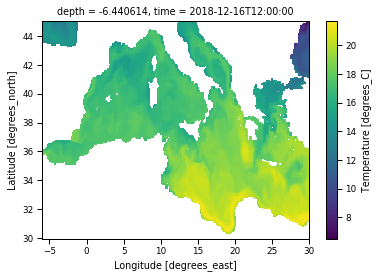

In [7]:
ds[temp_var].isel(time=11, depth=5).plot();

In [8]:
z = ds['depth'][0:20]
pcm_features = {'temperature': z}
features_in_ds = {'temperature': temp_var}
features_zdim=z_dim

## Predict labels
***

In [9]:
m.predict(ds, features=features_in_ds, dim=features_zdim, inplace=True);

In [10]:
m.predict_proba(ds, features=features_in_ds, dim=features_zdim, inplace=True);

In [11]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=temp_var, outname=temp_var + '_Q', keep_attrs=True, inplace=True)

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Plot results
***

In [12]:
P = Plotter(ds, m)

#### 1. Vertical structure of classes

Figure saved in figures/test.png


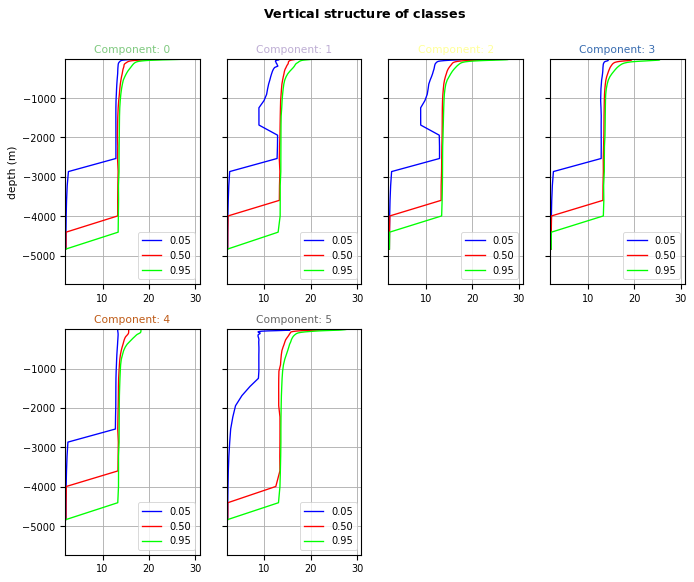

In [13]:
P.vertical_structure(q_variable = temp_var + '_Q', maxcols=4, figsize=(10, 8), sharey=True)
P.save_BlueCloud('figures/test.png')

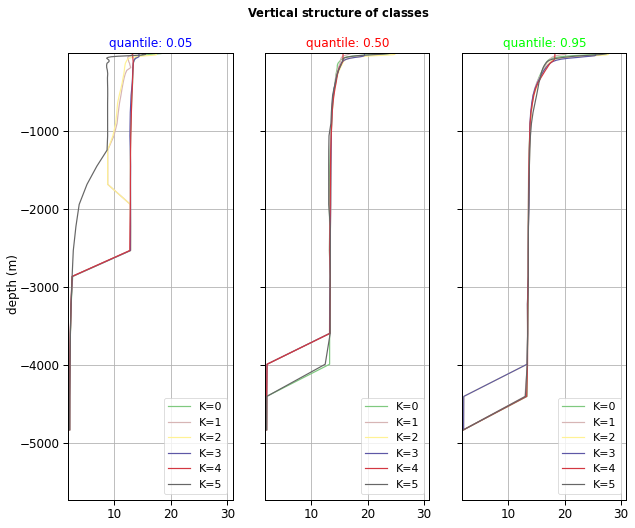

In [18]:
P.vertical_structure_comp(q_variable = temp_var + '_Q', plot_q='all')

#### 2. Spatial distribution of classes

Figure saved in figures/tets.png


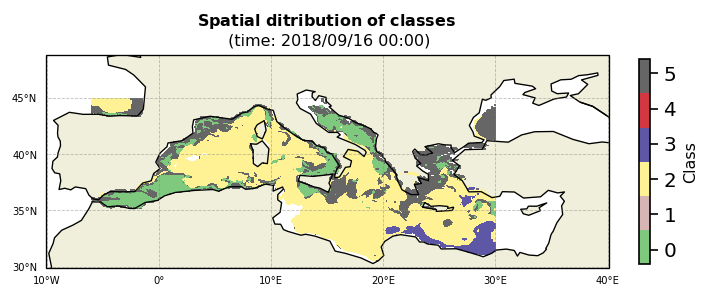

In [15]:
# TODO: when using isel hours are not good
# Input should have only one time step
P.spatial_distribution(proj=ccrs.PlateCarree(), 
                        extent=np.array([-10,40,30,46]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                        time_slice=8)

P.save_BlueCloud('figures/tets.png')

Figure saved in figures/spatial_distr_freq_EX.png


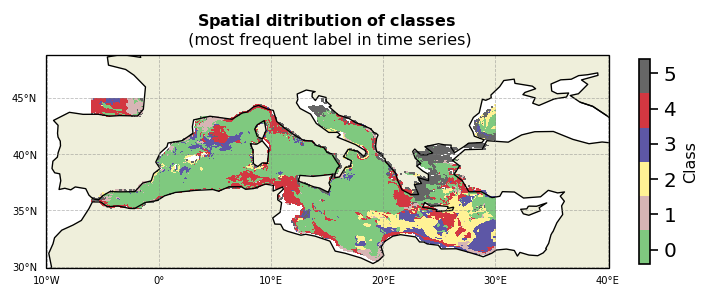

In [16]:
P.spatial_distribution(proj=ccrs.PlateCarree(), 
                        extent=np.array([-10,40,30,46]) + np.array([-0.1,+0.1,-0.1,+0.1]),
                        time_slice='most_freq_label')
P.save_BlueCloud('figures/spatial_distr_freq_EX.png')

#### 3. Posteriors

/home1/homedir5/perso/agarciaj/WORK/JUPYTER-notebooks/BlueCloud/Plotter.py:484: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


Figure saved in figures/test.png


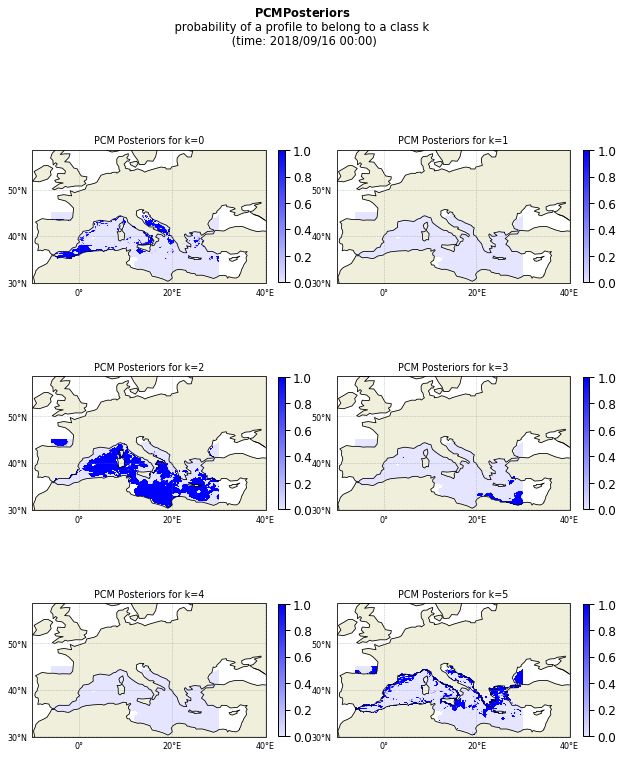

In [17]:
# Input should have only one time step
P.plot_posteriors(proj=ccrs.PlateCarree(), extent=np.array([-10,40,30,56]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                       time_slice=8)
P.save_BlueCloud('figures/test.png')

#### 4. Classes piue chart

Figure saved in figures/test.png


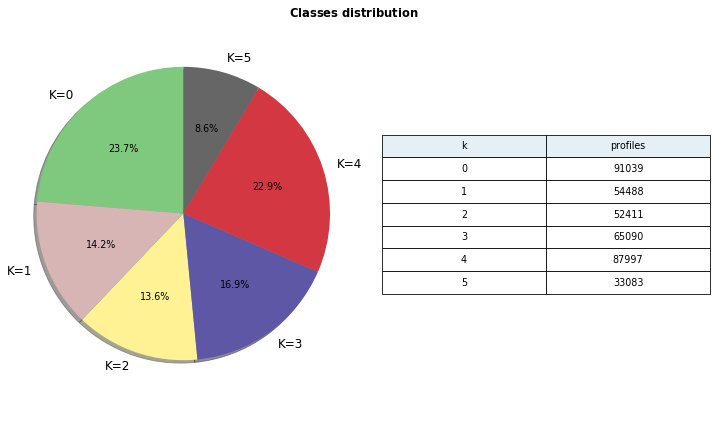

In [19]:
P.pie_classes()
P.save_BlueCloud('figures/test.png')

#### 4. Temporal representation 

Bar plot by __month__

Figure saved in figures/temporal_distr_months_EX.png


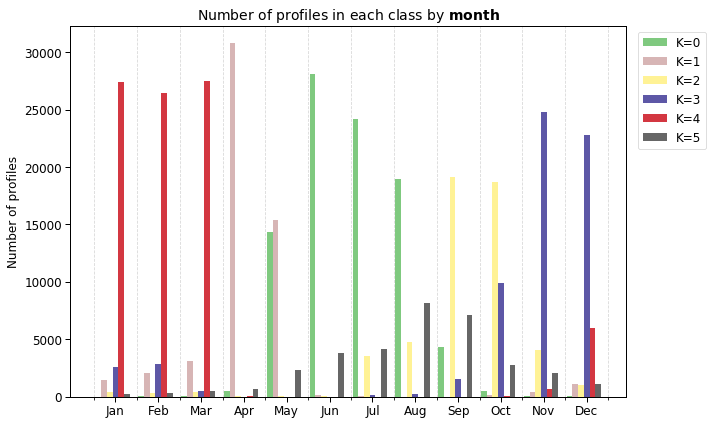

In [20]:
P.temporal_distribution(time_variable = 'time', time_bins = 'month', pond = 'abs')
P.save_BlueCloud('figures/temporal_distr_months_EX.png')

Bar plot by __month__ (__relative__ number of profiles per month)

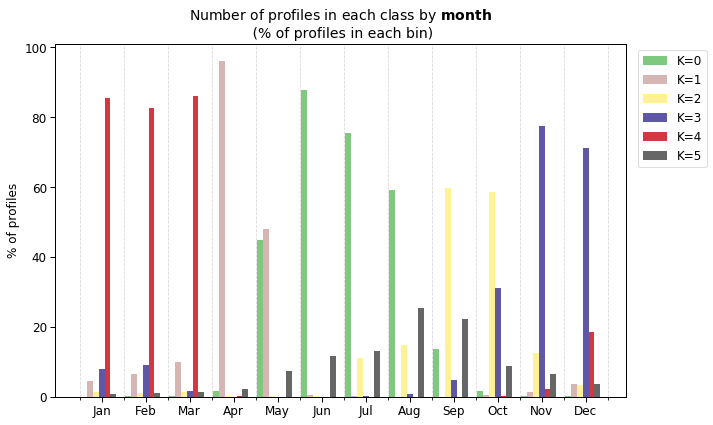

In [21]:
P.temporal_distribution(time_variable = 'time', time_bins = 'month', pond = 'rel')

Bar plot by __season__

Figure saved in figures/temporal_distr_season_EX.png


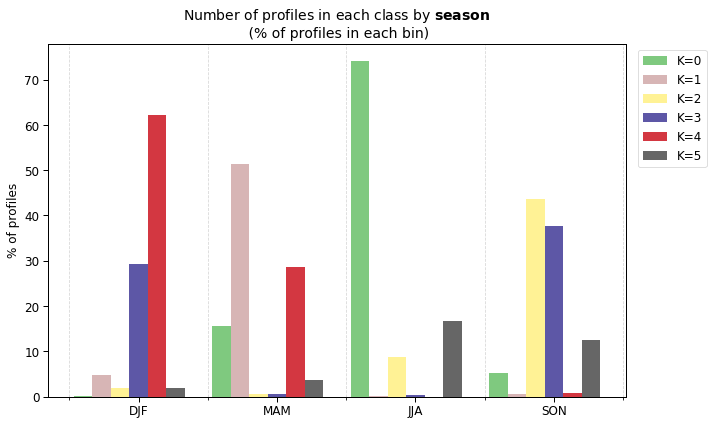

In [22]:
P.temporal_distribution(time_variable = 'time', time_bins = 'season', pond = 'rel')
P.save_BlueCloud('figures/temporal_distr_season_EX.png')